In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time

#The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.
def rffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    #window = get_window("hanning", ys.shape[1])
    #window = np.ones(ys.shape[1])
    #print(window.shape)
    #print(ys.shape)

    #ys_windowed = ys * window[np.newaxis, :]
    Ys = fft.rfft(ys, axis = 1) 
    
    return Ys

def filtering_func(freqs, fft, f1, f2):
    filtered_fft = fft.copy() #in this way it doesn't reference to fft

    fft_in_range = fft[(freqs >= f1) & (freqs <= f2)]

    range_avg = np.mean(fft_in_range)
    print(f'range_avg: {range_avg}')
    peak = np.max(fft_in_range)

    peak_indices = np.where(fft_in_range == peak)[0]
    peak_f = freqs[(freqs >= f1) & (freqs <= f2)][peak_indices]
    print(f"peak_f: {peak_f}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    filtered_fft[np.isin(freqs, peak_f)] = range_avg
    return filtered_fft

In [2]:
hour = '15.42'
day = '08082024'

In [3]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []


if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)
N = len(times)
print(f"len(times): {N}")

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
len(times): 62504


In [4]:
print(all_amplitudes)

[[-1.968504  -1.574803  -1.181102  ... -0.3937007 -1.181102  -1.181102 ]
 [ 1.574803   0.7874015  0.        ... -0.3937007 -2.755905  -4.724409 ]
 [-0.3937007 -0.3937007  0.3937007 ... -0.7874015 -2.362205  -3.149606 ]
 ...
 [-3.149606  -2.755905  -1.181102  ...  3.149606   3.149606   2.755905 ]
 [ 1.574803   1.574803   1.574803  ...  3.149606   3.149606   1.574803 ]
 [ 1.181102   1.574803   2.755905  ...  2.755905   1.968504   2.362205 ]]


## FFT

In [5]:
Ys = np.abs(rffts(all_amplitudes))
avg_fft = np.mean(Ys, axis = 0) 
n = np.max(avg_fft)

In [6]:
avg_fft_au = avg_fft / n

span: 50.00240067
f_s = 1250.0199822905822
625.0099911452911


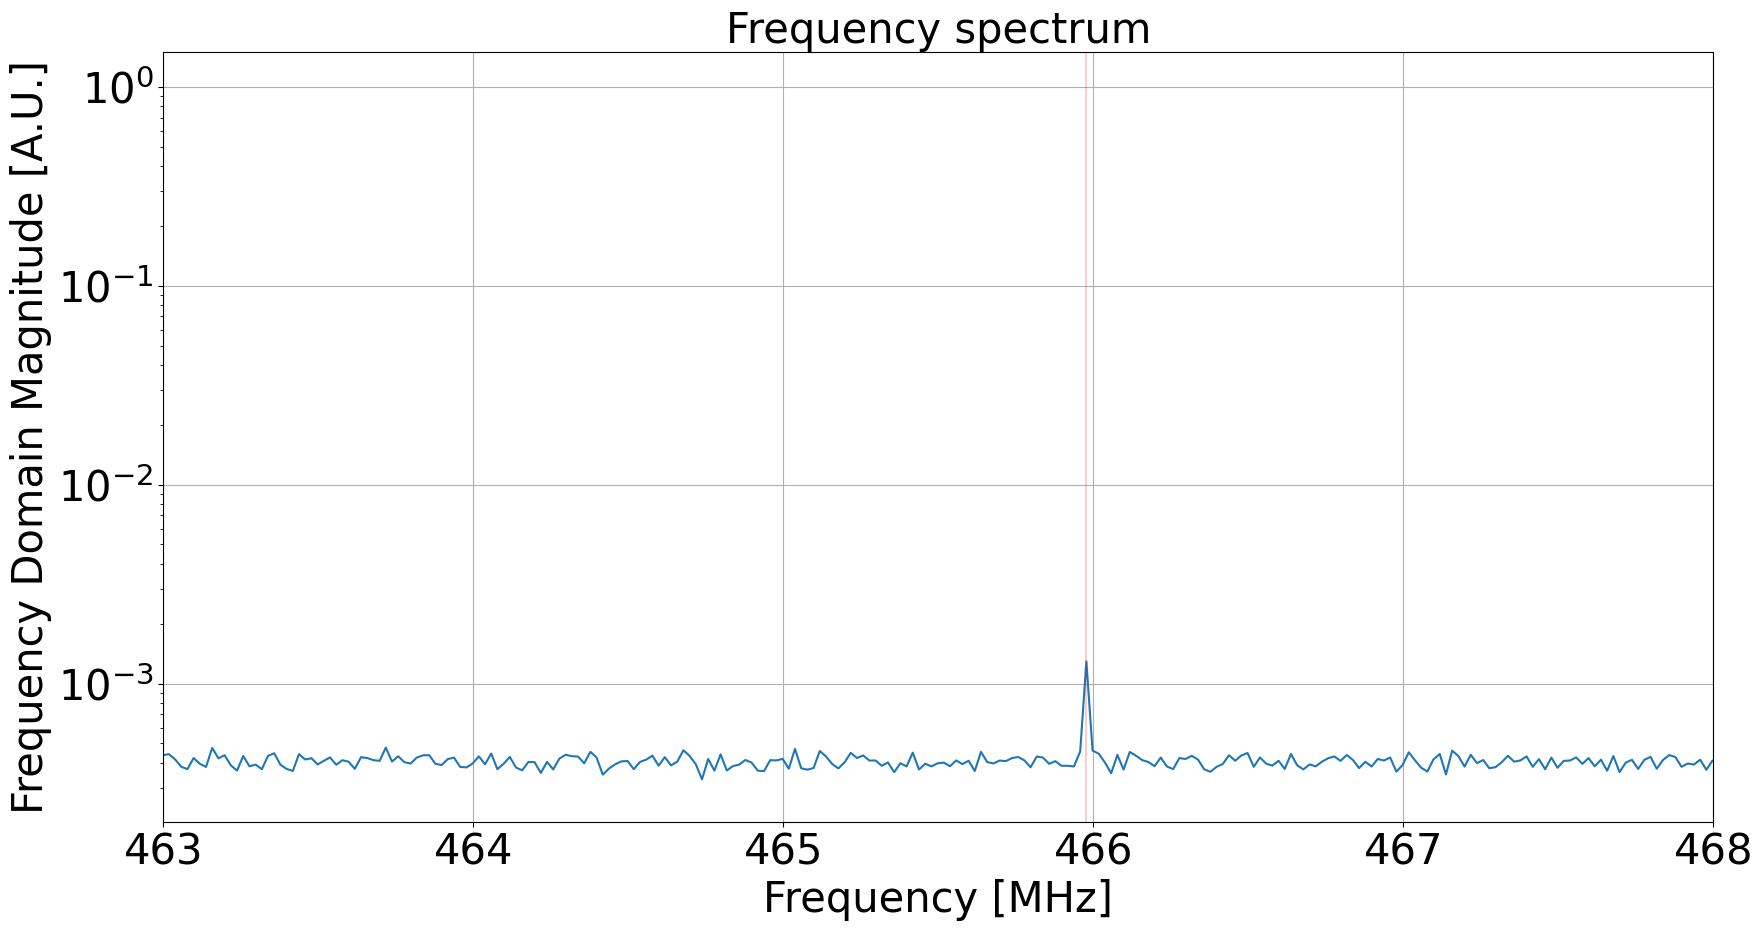

In [7]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.rfftfreq(all_amplitudes.shape[1], 1/f_s) #window lenght, sample spacing
print(freqs[-1])
f_s_new = 10 * freqs[-1]


f1 = 463
f2 = 468

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, avg_fft_au)

plt.axvline(465.97762683, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Filtering

In [8]:
#filtered_fft = filtering_func(freqs, avg_fft_au, f1, f2)
filtered_fft = filtering_func(freqs, avg_fft_au, f1, f2)

range_avg: 0.0004081262997163187
peak_f: [465.97762683]
sum: 1


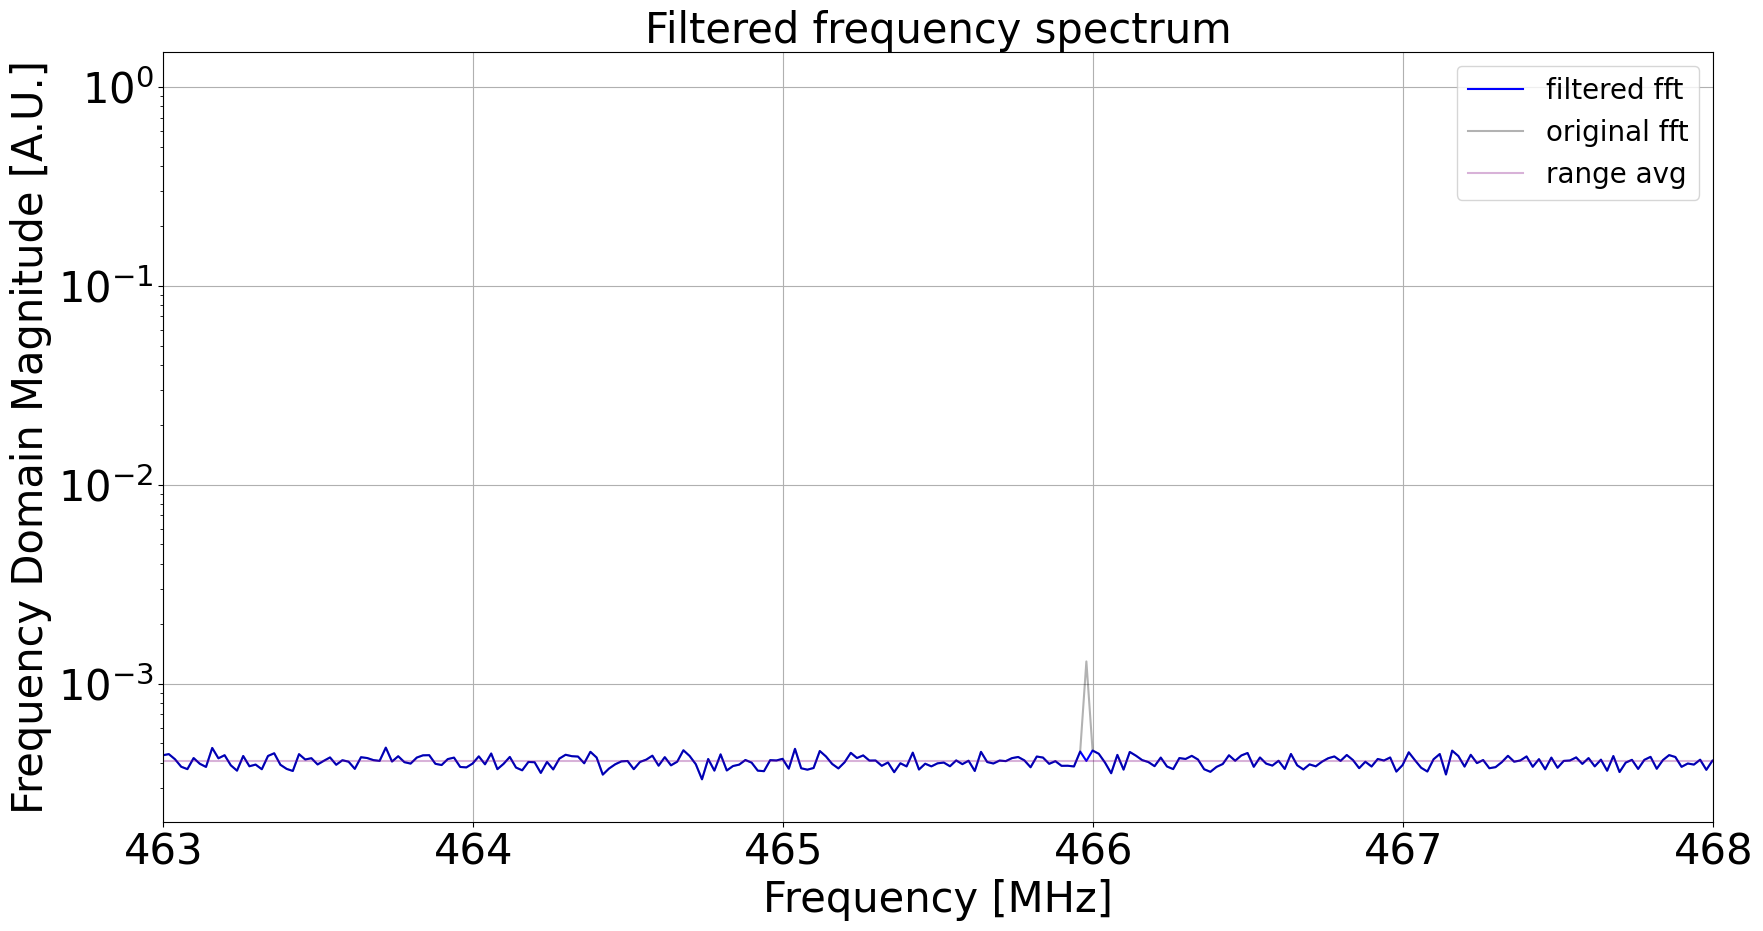

In [9]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, filtered_fft, color = 'blue', label = 'filtered fft')
plt.plot(freqs, avg_fft_au, alpha = 0.3, color = 'k', label = 'original fft')
plt.axhline( 0.0004081262997163187, color = 'purple', alpha = 0.3, label = 'range avg')

#plt.axvline(465.97762683, color = 'red')
plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
plt.legend(loc = 'best', fontsize = 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## IFFT

In [10]:
print(N)
print(f_s_new)
times_ifft = np.arange(N) / f_s_new
amplitudes_ifft = fft.irfft(filtered_fft)

62504
6250.099911452911


## Compare to average waveform

In [11]:
original_wf = fft.irfft(avg_fft_au)

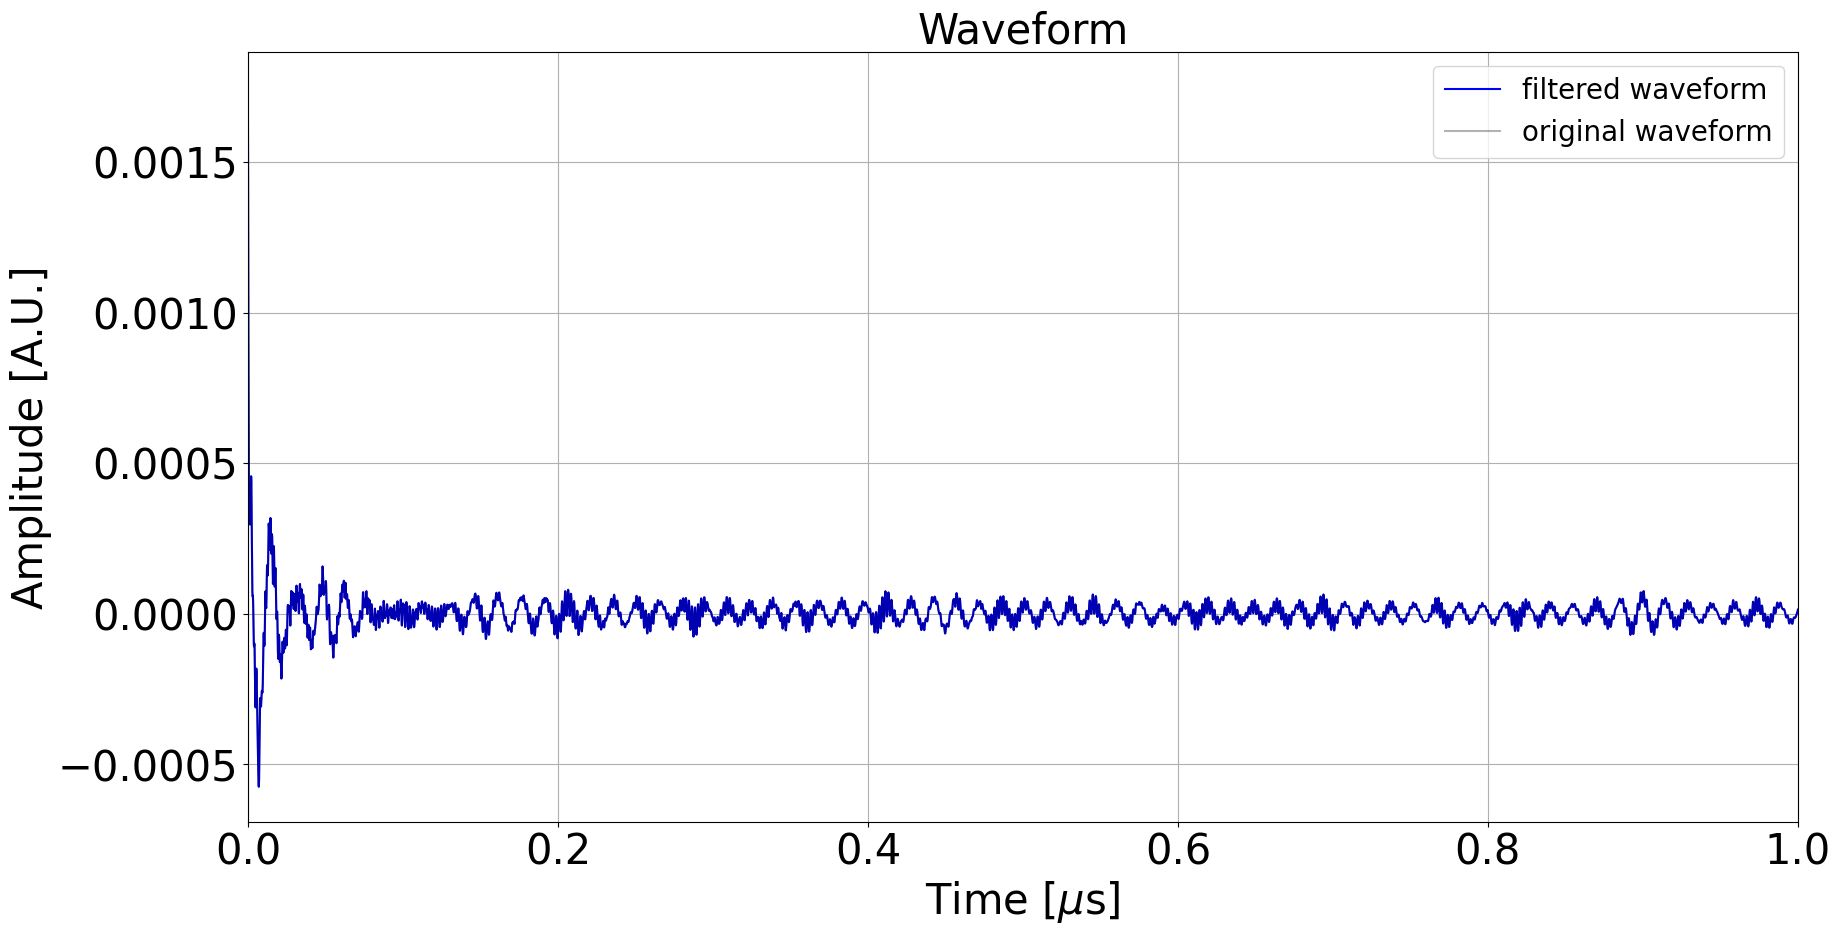

In [12]:
plt.figure(figsize = (20, 10))
plt.plot(times_ifft, amplitudes_ifft, label = 'filtered waveform', color = 'blue')
plt.plot(times_ifft, original_wf, label = 'original waveform', color = 'k', alpha = 0.3)
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

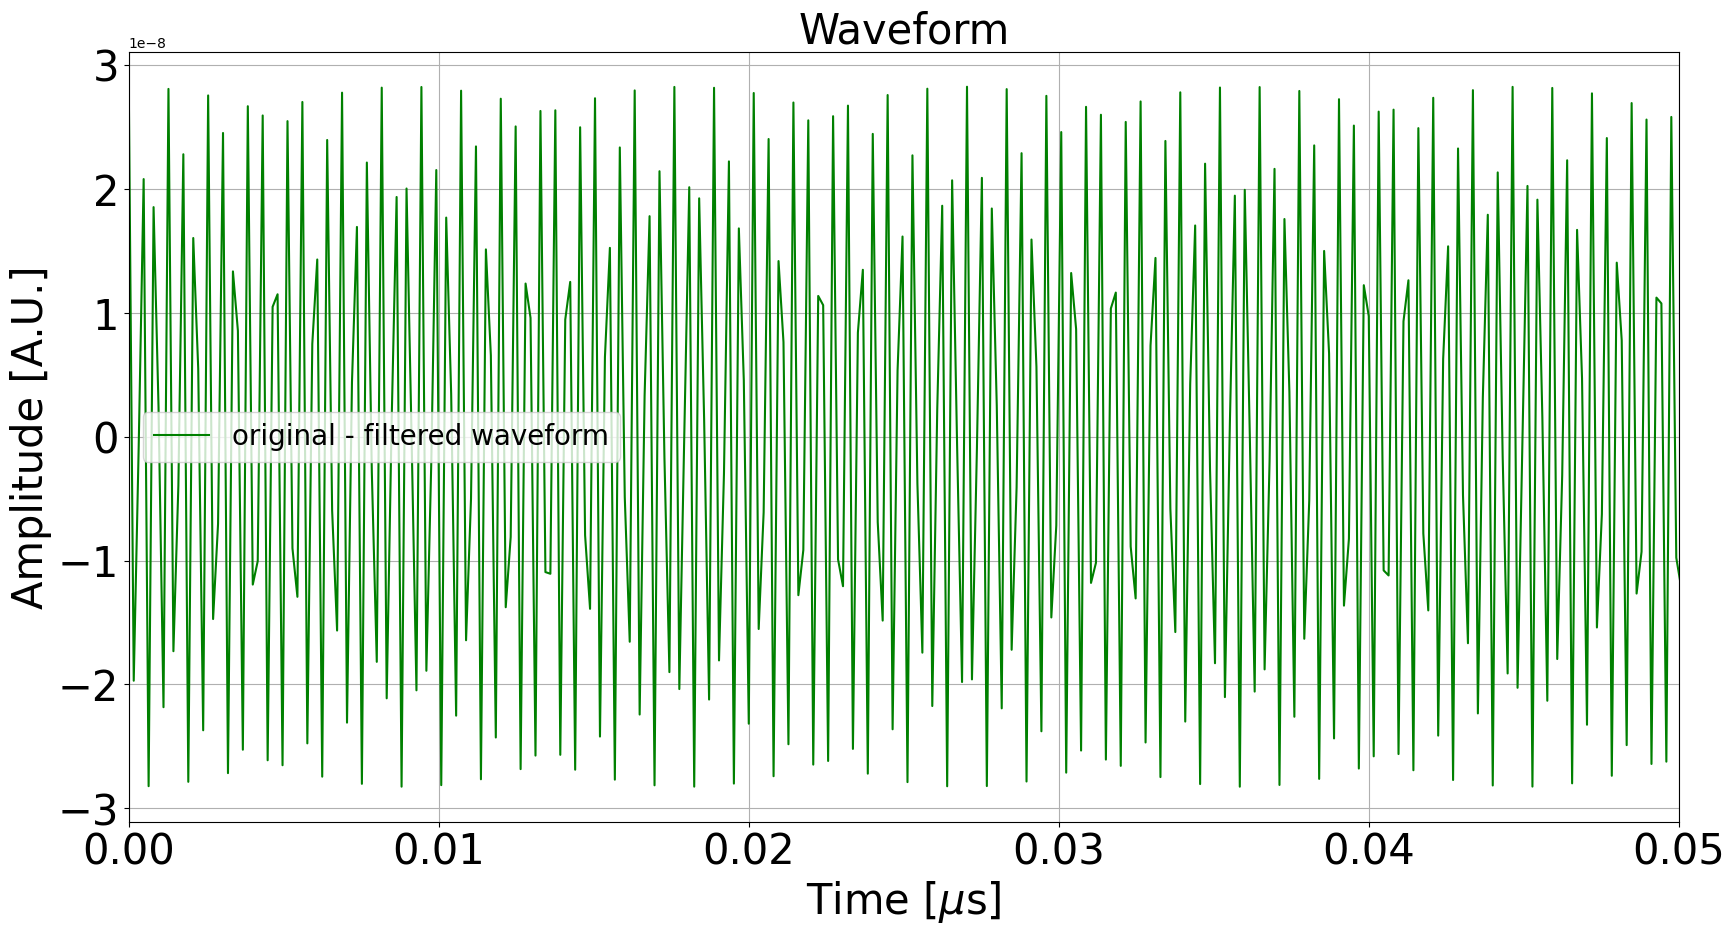

In [13]:
plt.figure(figsize = (20, 10))
plt.plot(times_ifft, original_wf - amplitudes_ifft, label = 'original - filtered waveform', color = 'green')
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.05)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [14]:
#CHECK THIS WITH 2 SIMPLE WF reconstructed wf not original wf